# Penalized Logistic Regression Trained on Rocks versus Mines Data

In [1]:
import sys
from math import sqrt, fabs, exp
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
def S(z, gamma):
    
    if gamma >= fabs(z):
        return 0.0
    
    elif z > 0.0:
        return z - gamma
    
    else:
        return z + gamma

In [3]:
def Pr(b0, b, x):
    n = len(x)
    total = b0
    
    for i in range(n):
        total += b[i] * x[i]
        
        if total < -100:
            total = -100
            
    return 1.0/(1.0 + exp(-total))

In [4]:
x_list = []
data_path = './data/sonar.all-data'

with open(data_path) as data:
    
    for line in data:
        # split on comma
        row = line.strip().split(',')
        x_list.append(row)
        
# separate labels from attributes, convert from attributes from string to numeric and covert "M" to 1 and "R" to 0
x_num = []
labels = []

for row in x_list:
    last_col = row.pop()
    
    if last_col == 'M':
        labels.append(1.0)
        
    else:
        labels.append(0.0)
        
    attr_row = [float(elt) for elt in row]
    x_num.append(attr_row)

In [5]:
# number of rows and columns in x matrix
n_row = len(x_num)
n_col = len(x_num[1])

alpha = 0.8

# calculate means and variances
x_means = []
x_sd = []

for i in range(n_col):
    col = [x_num[j][i] for j in range(n_row)]
    mean = sum(col)/n_row
    x_means.append(mean)
    
    col_diff = [(x_num[j][i] - mean) for j in range(n_row)]
    sum_sq = sum([col_diff[i] ** 2 for i in range(n_row)])
    std_dev = sqrt(sum_sq/n_row)
    x_sd.append(std_dev)
    
# use calculated mean and standard deviation to normalize x_num
x_normalized = []

for i in range(n_row):
    row_normalized = [(x_num[i][j] - x_means[j])/x_sd[j] for j in range(n_col)]
    x_normalized.append(row_normalized)
    
# Do not normalized labels but do calculate averages
mean_label = sum(labels)/n_row
sd_label = sqrt(sum([(labels[i] - mean_label) * (labels[i] - mean_label) for i in range(n_row)])/n_row)
    

In [6]:
# initialize probabilities and weights
sum_Wxr = [0.0] * n_col
sum_Wxx = [0.0] * n_col
sum_Wr = 0.0
sum_W = 0.0

# calculate starting points for betas
for i_row in range(n_row):
    p = mean_label
    w = p * (1.0 - p)
    
    # residual for logistic
    r = (labels[i_row] - p)/w
    x = x_normalized[i_row]
    
    sum_Wxr = [sum_Wxr[i] + w * x[i] * r for i in range(n_col)]
    sum_Wxx = [sum_Wxx[i] + w * x[i] * x[i] for i in range(n_col)]
    sum_Wr = sum_Wr + w * r
    sum_W = sum_W + w
    
avg_Wxr = [sum_Wxr[i]/n_row for i in range(n_col)]
avg_Wxx = [sum_Wxx[i]/n_row for i in range(n_col)]
max_Wxr = 0.0

for i in range(n_col):
    val = abs(avg_Wxr[i])
    
    if val > max_Wxr:
        max_Wxr = val

In [7]:
# calculate starting value for lambda
lam = max_Wxr/alpha

# this value of lambda corresponds to beta = list of 0s
# initialize a vector of coefficients beta
beta = [0.0] * n_col
beta0 = sum_Wr/sum_W

# initialize matrix of betas at each step
beta_mat = []
beta_mat.append(list(beta))

beta0_list = []
beta0_list.append(beta0)

# begin iteration
# 100 steps gives reduction by factor of 1000 in lambda (recommended by authors)
n_steps = 100
lam_mult = 0.93
nz_list = []

for i_step in range(n_steps):
    # decrease lambda
    lam = lam * lam_mult
    
    # use incremental change in betas to control inner iteration
    
    # set middle loop values for betas = to outer values
    # values are used for calculating weights and probabilities
    # inner values are used for calculating penalized regression updates
    
    # take pass through data to calculate averages over data required for iteration
    # initialize accumulators
    
    beta_IRLS = list(beta)
    beta0_IRLS = beta0
    dist_IRLS = 100.0
    
    # Middle loop to calculate new betas with fixed IRLS weights and probabilities
    iter_IRLS = 0
    
    while dist_IRLS > 0.01:
        iter_IRLS += 1
        iter_inner = 0.0
        
        beta_inner = list(beta_IRLS)
        beta0_inner = beta0_IRLS
        dist_inner = 100.0
        
        while dist_inner > 0.01:
            iter_inner += 1
            
            if iter_inner > 100:
                break
                
            # cycle through attribuets and update one at a time
            # record starting value for comparison
            beta_start = list(beta_inner)
            
            for i_col in range(n_col):
                sum_Wxr = 0.0
                sum_Wxx = 0.0
                sum_Wr = 0.0
                sum_W = 0.0
                
                for i_row in range(n_row):
                    x = list(x_normalized[i_row])
                    y = labels[i_row]
                    p = Pr(beta0_IRLS, beta_IRLS, x)
                    
                    if abs(p) < 1e-5:
                        p = 0.0
                        w = 1e-5
                        
                    elif abs(1.0 - p) < 1e-5:
                        p = 1.0
                        w = 1e-5
                    
                    else:
                        w = p * (1.0 - p)
                        
                    z = (y - p)/w + beta0_IRLS + sum([x[i] * beta_IRLS[i] for i in range(n_col)])
                    r = z - beta0_inner - sum([x[i] * beta_inner[i] for i in range(n_col)])
                    
                    sum_Wxr += w * x[i_col] * r
                    sum_Wxx += w * x[i_col] * x[i_col]
                    sum_Wr += w * r
                    sum_W += w
                
                avg_Wxr = sum_Wxr/n_row
                avg_Wxx = sum_Wxx/n_row
                
                beta0_inner = beta0_inner + sum_Wr/sum_W
                unc_beta = avg_Wxr + avg_Wxx * beta_inner[i_col]
                beta_inner[i_col] = S(unc_beta, lam * alpha)/(avg_Wxx + lam * (1.0 - alpha))
                
            sum_diff = sum([abs(beta_inner[n] - beta_start[n]) for n in range(n_col)])
            sum_beta = sum([abs(beta_inner[n]) for n in range(n_col)])
            dist_inner = sum_diff/sum_beta
        
        # print number of steps for inner and middle loop convergence to monitor behavior
        print(i_step, iter_IRLS, iter_inner)
        
        # if exit inner while loop, then set beta_middle = beta_middle and run through middle loop again
        
        # check change in beta_middle to see if IRLS is converged
        a = sum([abs(beta_IRLS[i] - beta_inner[i]) for i in range(n_col)])
        b = sum([abs(beta_IRLS[i]) for i in range(n_col)])
        dist_IRLS = a/(b + 0.0001)
        d_beta = [beta_inner[i] - beta_IRLS[i] for i in range(n_col)]
        grad_step = 1.0
        temp = [beta_IRLS[i] + grad_step * d_beta[i] for i in range(n_col)]
        beta_IRLS = list(temp)
    
    beta = list(beta_IRLS)
    beta0 = beta0_IRLS
    beta_mat.append(list(beta))
    beta0_list.append(beta0)
    
    nz_beta = [index for index in range(n_col) if beta[index] != 0.0]
    
    for q in nz_beta:
        
        if not (q in nz_list):
            nz_list.append(q)

0 1 2.0
0 2 1.0
1 1 2.0
1 2 1.0
2 1 2.0
2 2 1.0
3 1 3.0
3 2 1.0
4 1 4.0
4 2 1.0
5 1 5.0
5 2 1.0
6 1 4.0
6 2 1.0
7 1 4.0
7 2 1.0
8 1 4.0
8 2 1.0
9 1 3.0
9 2 1.0
10 1 3.0
10 2 1.0
11 1 3.0
11 2 1.0
12 1 3.0
12 2 1.0
13 1 4.0
13 2 1.0
14 1 4.0
14 2 1.0
15 1 4.0
15 2 1.0
16 1 4.0
16 2 1.0
17 1 4.0
17 2 1.0
18 1 4.0
18 2 1.0
19 1 4.0
19 2 1.0
20 1 4.0
20 2 1.0
21 1 4.0
21 2 1.0
22 1 4.0
22 2 1.0
23 1 4.0
23 2 1.0
24 1 4.0
24 2 1.0
25 1 4.0
25 2 1.0
26 1 4.0
26 2 1.0
27 1 4.0
27 2 1.0
28 1 4.0
28 2 1.0
29 1 4.0
29 2 2.0
30 1 4.0
30 2 2.0
31 1 4.0
31 2 2.0
32 1 4.0
32 2 2.0
33 1 4.0
33 2 2.0
34 1 4.0
34 2 3.0
34 3 2.0
35 1 4.0
35 2 2.0
35 3 2.0
36 1 4.0
36 2 3.0
36 3 2.0
37 1 5.0
37 2 2.0
37 3 2.0
38 1 5.0
38 2 2.0
38 3 2.0
39 1 5.0
39 2 2.0
39 3 2.0
40 1 5.0
40 2 2.0
40 3 2.0
41 1 5.0
41 2 2.0
41 3 2.0
42 1 4.0
42 2 2.0
42 3 2.0
43 1 4.0
43 2 2.0
43 3 2.0
43 4 1.0
44 1 4.0
44 2 2.0
44 3 1.0
45 1 4.0
45 2 2.0
45 3 2.0
45 4 1.0
46 1 4.0
46 2 2.0
46 3 1.0
47 1 4.0
47 2 2.0
47 3 1.0
48 1 4.0
48 

In [8]:
# make up names for columns of x_num
names = [f'V{str(i)}' for i in range(n_col)]
name_list = [names[nz_list[i]] for i in range(len(nz_list))]

print('Attributes Ordered by How Early They Enter the Model')
print(name_list)

Attributes Ordered by How Early They Enter the Model
['V10', 'V48', 'V11', 'V44', 'V35', 'V51', 'V20', 'V3', 'V50', 'V21', 'V43', 'V47', 'V15', 'V27', 'V0', 'V22', 'V36', 'V30', 'V53', 'V56', 'V58', 'V6', 'V19', 'V28', 'V39', 'V49', 'V7', 'V23', 'V54', 'V8', 'V14', 'V2', 'V29', 'V38', 'V57', 'V45', 'V13', 'V32', 'V31', 'V42', 'V16', 'V37', 'V59', 'V52', 'V25', 'V18', 'V1', 'V33', 'V4', 'V55', 'V17', 'V46', 'V26', 'V12', 'V40', 'V34', 'V5', 'V24', 'V41', 'V9']


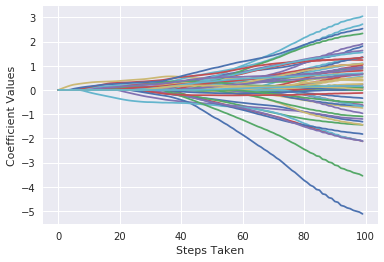

In [9]:
for i in range(n_col):
    # plot range of beta values for each attribute
    coef_curve = [beta_mat[k][i] for k in range(n_steps)]
    x_axis = range(n_steps)
    plt.plot(x_axis, coef_curve)
    
plt.xlabel('Steps Taken')
plt.ylabel('Coefficient Values')
plt.show()